In [1]:
import torch
import math
from torch.utils import data
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch import nn
import numpy as np
from scipy.sparse import coo_matrix

import scipy.optimize
import sympy

In [2]:
# Set seed
seed = np.random.randint(10000)
torch.manual_seed(seed)
np.random.seed(seed)

## Data generation

In [3]:
def getData(data_size):
    data_size_class = data_size // 2
    temp = torch.ones(data_size_class, 2)

    B = torch.normal(4 * temp, 1)

    By = torch.ones(data_size_class)
    A = torch.normal(0 * temp, 1)
    Ay = torch.zeros(data_size_class)

    X = torch.cat([A, B], 0)
    Y = torch.cat([Ay, By]).type(torch.float)
    
    return X,Y

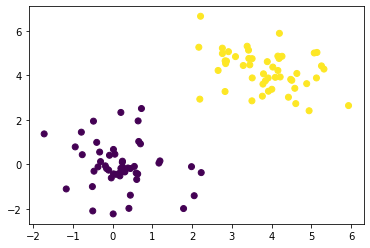

In [4]:
data_size = 100
data,labels = getData(data_size)

plt.scatter(data.data.numpy()[:,0],data.data.numpy()[:,1],c=labels)
plt.show()

In [5]:
data = data.unsqueeze(2)
labels = labels.unsqueeze(1)

## Integrator

In [6]:
t_end = 1
n_layers = 5
h = t_end / n_layers

alpha = 0
learning_rate = 0.1
max_iteration = 50

In [7]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1'):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers)
            b = torch.randn(self.nf, 1, self.n_layers)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers)
            b = torch.zeros(self.nf, 1, self.n_layers)

        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))

        NNoutput = Y.transpose(1, dim-1)

        return NNoutput

In [8]:
def regularization(alpha, h, K, b):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2)
    return loss

In [9]:
model = H1(n_layers, t_end, nf=2, select_j='J1')

In [10]:
loss_func = nn.BCEWithLogitsLoss()
optimizer_k = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
def compute_H(y,K,b):
    n_layers = K.shape[-1]
    H = torch.sum(torch.log(torch.cosh(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1]))),1)
    return H

In [12]:
def compute_th(H):    
    H_a = H[0:data_size//2].detach().numpy()
    H_b = H[data_size//2+1:data_size].detach().numpy()

    #mean
    mu_a = np.mean(H_a)
    mu_b = np.mean(H_b)

    #covariance
    cov_a_i = 1 / np.cov(H_a).item()
    cov_b_i = 1 / np.cov(H_b).item()

    A = -0.5*(cov_a_i-cov_b_i)
    B = (mu_a*cov_a_i - mu_b*cov_b_i)
    C = -0.5*(mu_a*cov_a_i*mu_a - mu_b*cov_b_i*mu_b)

    x = scipy.optimize.fsolve(lambda x: A*x**2 + B*x + C, (mu_a+mu_b)/2)
    return x

In [13]:
for epoch in range(max_iteration):
    
    # optimizer_w = torch.optim.Adam(model_c.parameters(), lr=learning_rate)
    with torch.no_grad():
        YN = model(data)

    optimizer_k.zero_grad()
    K = model.getK()
    b = model.getb()
    loss = loss_func(compute_H(YN,K,b).unsqueeze(1), labels)
    loss += regularization(alpha, h, K, b)
    loss.backward()
    optimizer_k.step()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            YN = model(data)
            th = compute_th(compute_H(YN,K,b))[0]
            acc = (torch.ge(compute_H(YN,K,b).unsqueeze(1), th) == labels).sum().numpy() / data_size
        print('\tTrain Epoch: {:2d} - Loss: {:.6f} - Accuracy: {:.0f}%'.format(epoch, loss, acc*100))

	Train Epoch:  0 - Loss: 0.982158 - Accuracy: 68%
	Train Epoch: 10 - Loss: 0.585875 - Accuracy: 97%
	Train Epoch: 20 - Loss: 0.417229 - Accuracy: 100%
	Train Epoch: 30 - Loss: 0.418577 - Accuracy: 100%
	Train Epoch: 40 - Loss: 0.407829 - Accuracy: 100%


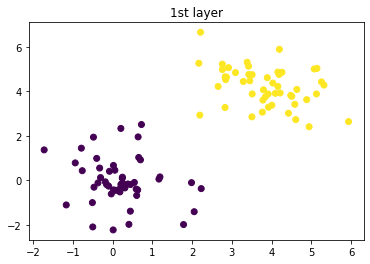

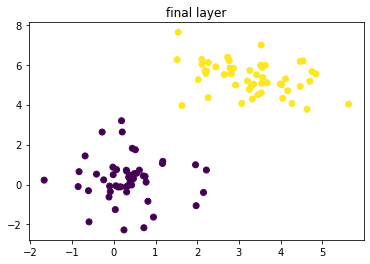

In [14]:
plt.scatter(data.data.numpy()[:,0],data.data.numpy()[:,1],c=labels)
plt.title('1st layer')
plt.show()

plt.scatter(YN.data.numpy()[:,0],YN.data.numpy()[:,1],c=labels)
plt.title('final layer')
plt.show()

## Compute energy and threshold

In [15]:
H = compute_H(YN,K,b)

In [16]:
H_a = H[0:data_size//2].detach().numpy()
H_b = H[data_size//2+1:data_size].detach().numpy()

#mean
mu_a = np.mean(H_a)
mu_b = np.mean(H_b)


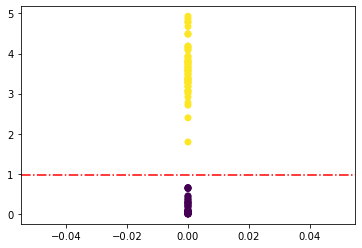

Training accuracy: 100.00%


In [17]:
plt.scatter(np.zeros(data_size),H.data.numpy(),c=labels)
plt.axhline(th, label='mean',linestyle='-.', color='r')
plt.show()

pred_train = (H.data.numpy()>th).astype(int)
if mu_a>mu_b:
    pred_train = -(pred_train) + 1
acc_train = (pred_train.T == labels.data.numpy().T).astype(int).sum() / data_size
print('Training accuracy: {:.2f}%'.format(acc_train*100))

## Testing

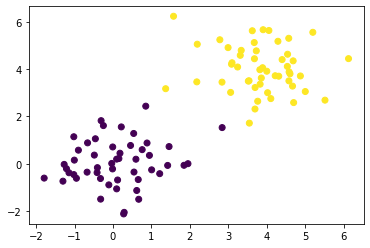

In [18]:
data_size_test = 100
data_test,labels_test = getData(data_size_test)

plt.scatter(data_test.data.numpy()[:,0],data_test.data.numpy()[:,1],c=labels_test)
plt.show()

data_test=data_test.unsqueeze(2)
labels_test = labels_test.unsqueeze(1)

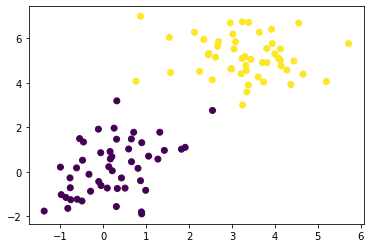

In [19]:
with torch.no_grad():
    YN_test = model(data_test)
plt.scatter(YN_test.data.numpy()[:,0],YN_test.data.numpy()[:,1],c=labels_test)
plt.show()

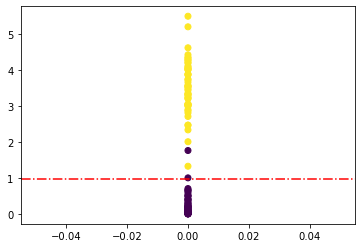

Testing accuracy: 91.00%


In [20]:
H_test = compute_H(YN_test,K,b)
plt.scatter(np.zeros(data_size_test),H_test.data.numpy(),c=labels_test)
plt.axhline(th, label='mean',linestyle='-.', color='r')
plt.show()

pred_test = (H_test.data.numpy()>th).astype(int)
if mu_a>mu_b:
    pred_test = -(pred_test) + 1
acc_test = (pred_test.T == labels_test.data.numpy().T).astype(int).sum() / data_size_test
acc_test = (torch.ge(compute_H(model(data_test),K,b).unsqueeze(1), 0.5) == labels_test).sum().numpy() / data_size_test
print('Testing accuracy: {:.2f}%'.format(acc_test*100))